### GGIS 480 Final Project Python Notebook

The COVID-19 pandemic has significantly impacted various sectors globally, including real estate. Understanding its effect on housing prices across different regions in the U.S. is crucial for stakeholders including multiple policymakers, urban planners, investors, and the public. In this research, I expect finding out how has the COVID-19 pandemic affected housing prices in different regions of the United States? What patterns of geographic clustering can be observed in these changes?

Data: Housing price data by month of each county in the year of 2019 and 2022 was collected from Zillow and was pre-processed in Excel to get the average housing prices by county for the year of 2019 and 2022, representing the situations before and after the Pandemic respectively. In addition, U.S. county boundary shp file was collected from U.S. Census Bureau.

Limitations: The housing price data of 103 counties is not available. They are excluded when conducting Moran analysis.

Delimitations: This study focuses on the mainland of the U.S. (Alaska, Hawaii and remote islands are not included) for detailed analysis. Multiple data sources are used to get the data as complete as possible.

Analysis: In the preliminary exploratory data analysis, maps will be created to illustrate the geographic distribution of housing prices in 2019 and 2022. These maps will visually display areas with high, moderate, and low housing prices, which are expected to show clusters rather than random distribution. The results from Moran’s I analysis would indicate the degree of spatial autocorrelation in housing prices. A high positive Moran’s I value would suggest a strong clustering pattern. Next, in the local Moran’s I analysis or called LISA (Local Indicators of Spatial Association), maps will be made to discover clusters of counties with similar housing prices with their neighbors (high-high, low-low) or dissimilar values (high-low, low-high), which can show the clustering patterns more clearly and price changes may be discovered. What's more, I also include the housing price growth rate from 2019 to 2022 in the same analysis process, which can further inform how the pandemic may have changed pre-existing trends in the housing market.


In [2]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.patches as mpatches
import os

In [2]:
# unzip gdb which contains county boundary shp file
!unzip Housing.gdb.zip

Archive:  Housing.gdb.zip
  inflating: Housing.gdb/a00000001.gdbindexes  
  inflating: Housing.gdb/a00000001.gdbtable  
  inflating: Housing.gdb/a00000001.gdbtablx  
  inflating: Housing.gdb/a00000001.TablesByName.atx  
  inflating: Housing.gdb/a00000002.gdbtable  
  inflating: Housing.gdb/a00000002.gdbtablx  
  inflating: Housing.gdb/a00000003.gdbindexes  
  inflating: Housing.gdb/a00000003.gdbtable  
  inflating: Housing.gdb/a00000003.gdbtablx  
  inflating: Housing.gdb/a00000004.CatItemsByPhysicalName.atx  
  inflating: Housing.gdb/a00000004.CatItemsByType.atx  
  inflating: Housing.gdb/a00000004.FDO_UUID.atx  
  inflating: Housing.gdb/a00000004.gdbindexes  
  inflating: Housing.gdb/a00000004.gdbtable  
  inflating: Housing.gdb/a00000004.gdbtablx  
  inflating: Housing.gdb/a00000004.spx  
  inflating: Housing.gdb/a00000005.CatItemTypesByName.atx  
  inflating: Housing.gdb/a00000005.CatItemTypesByParentTypeID.atx  
  inflating: Housing.gdb/a00000005.CatItemTypesByUUID.atx  
  inflati

In [111]:
# Reading geographic data file and housing price data
county=gpd.read_file("Housing.gdb")
housing=pd.read_csv("housing_prices.csv")

# Define output path
path_output="final project"

# Formatting State and Municipal Codes
housing["StateCodeFIPS"]=["%02d"%v for v in housing["StateCodeFIPS"]]
housing["MunicipalCodeFIPS"]=["%03d"%v for v in housing["MunicipalCodeFIPS"]]

In [112]:
# spatial join two datasets
county_housing=pd.merge(county,housing,left_on=["STATEFP","COUNTYFP"], right_on=["StateCodeFIPS","MunicipalCodeFIPS"],how="left")
county_housing["price_changes"]=[v*100 for v in county_housing["price_changes"]]

In [117]:
# color schemes for plotting
cmap1=clr.LinearSegmentedColormap.from_list("mycolor1",["#004da8","#0070fe","#c500fe","#fe0000","#a80000"])
cmap2=clr.LinearSegmentedColormap.from_list("mycolor2",["#34b2fb","#fdbba1","#fb6749","#cb181c","#65000a"])


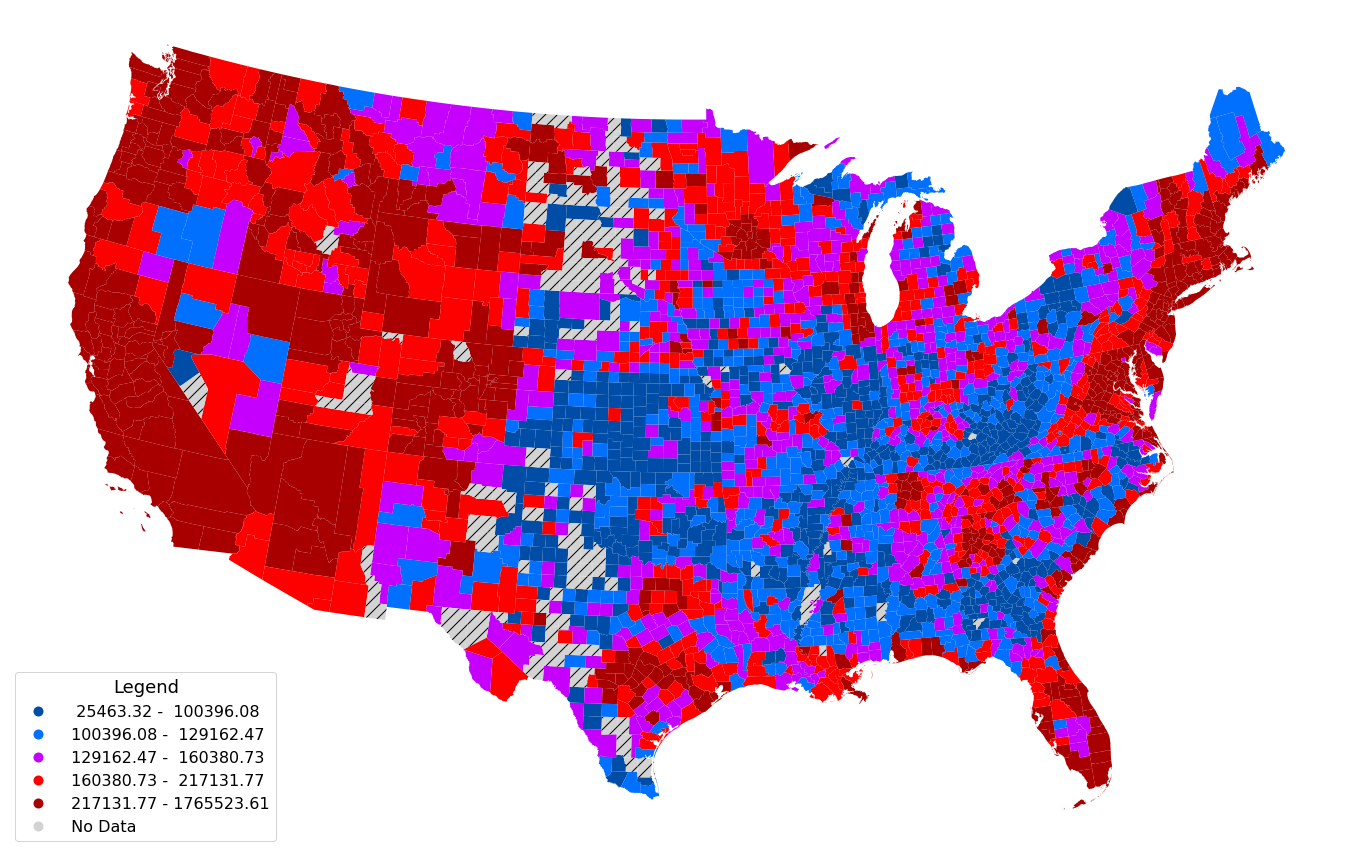

In [118]:
# Examine visually the geographic distribution of housing prices by county in 2019
plt.figure(1,figsize=(24,40))
plt.axis("off")
ax=county_housing.plot(column="avg_2019",ax=plt.gca(),legend=True,scheme="quantiles",cmap=cmap1,
                    legend_kwds={"loc":"lower left","title":"Legend","fontsize": 16,"title_fontsize": 18},
                    missing_kwds={"color":"lightgrey","hatch":"//","label":" No Data"})
leg=ax.get_legend()
leg_texts=leg.texts
for l in range(len(leg_texts)):
    leg.get_texts()[l].set_text(leg_texts[l].get_text().replace(", "," - "))
    
plt.savefig(os.path.join(path_output,"avg_2019.jpg"),dpi=600)

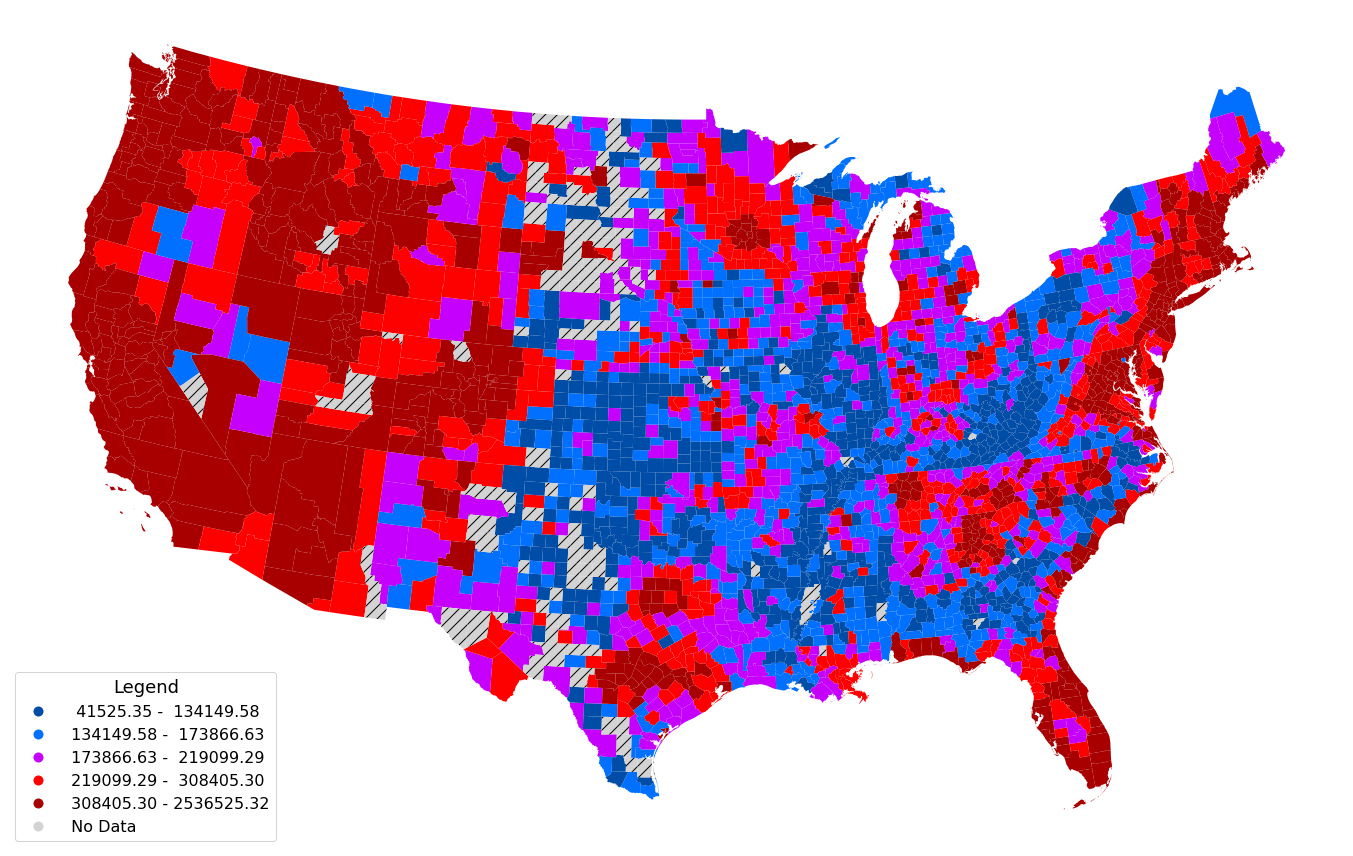

In [119]:
# Examine visually the geographic distribution of housing prices by county in 2022
plt.figure(2,figsize=(24,40))
plt.axis("off")
ax=county_housing.plot(column="avg_2022",ax=plt.gca(),legend=True,scheme="quantiles",cmap=cmap1,
                    legend_kwds={"loc":"lower left","title":"Legend","fontsize": 16,"title_fontsize": 18},
                    missing_kwds={"color":"lightgrey","hatch":"//","label":" No Data"})
leg=ax.get_legend()
leg_texts=leg.texts
for l in range(len(leg_texts)):
    leg.get_texts()[l].set_text(leg_texts[l].get_text().replace(", "," - "))
    
plt.savefig(os.path.join(path_output,"avg_2022.jpg"),dpi=600)

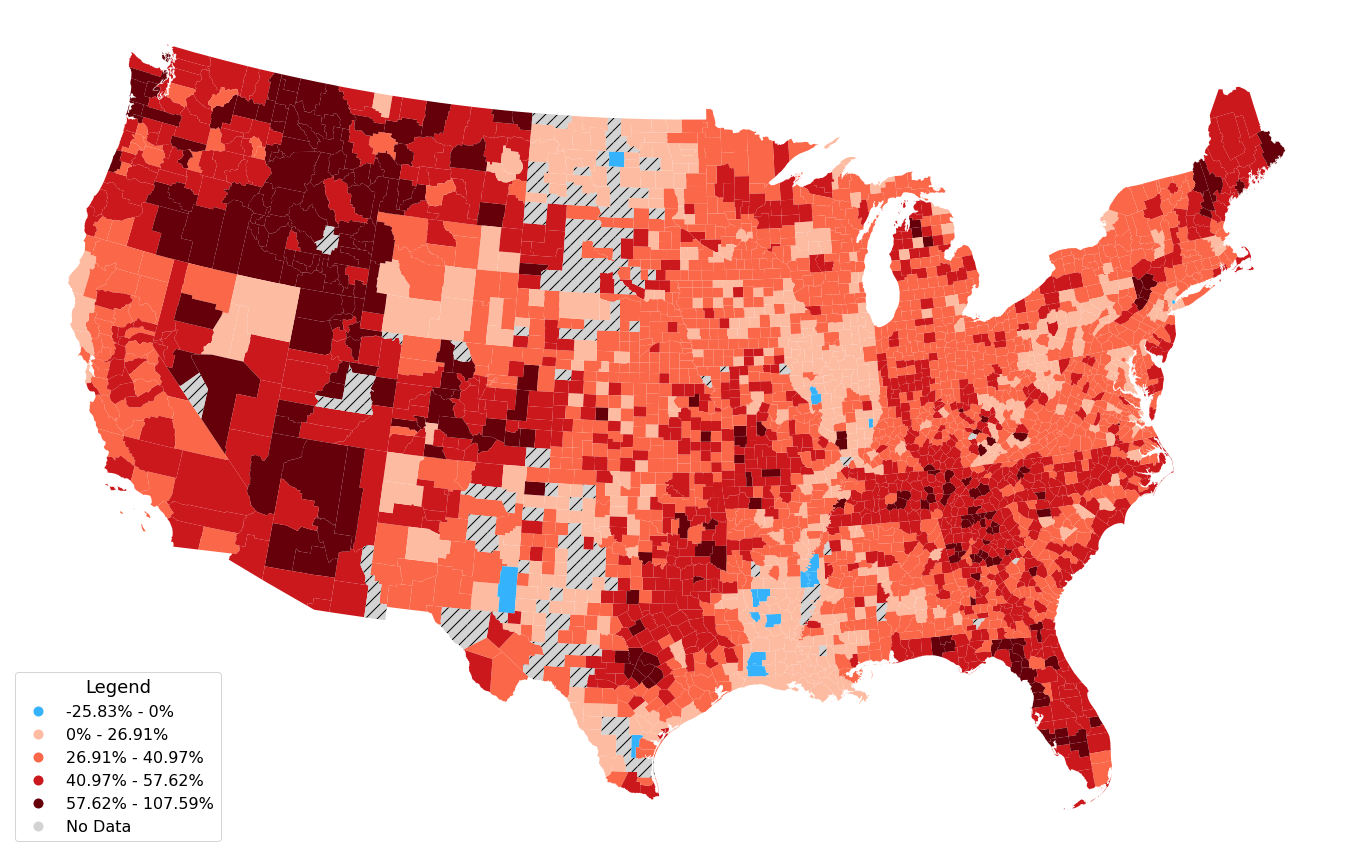

In [120]:
# Visual examination of the geographic distribution of housing price change from 2019 to 2022
from pysal.viz.mapclassify import NaturalBreaks

# Define a new column for the categorical data and separate negative values from positive values
county_housing['price_change_category'] = pd.cut(
    county_housing['price_changes'],
    bins=[-float('inf'), 0] + NaturalBreaks(county_housing[county_housing['price_changes'] >= 0]['price_changes'], k=4).bins.tolist(),
    include_lowest=True,
    labels=['-25.83% - 0%', '0% - 26.91%', '26.91% - 40.97%', '40.97% - 57.62%', '57.62% - 107.59%']
)

# Replace NaN values in 'price_change_category' with 'No Data'
county_housing['price_change_category'] = county_housing['price_change_category'].cat.add_categories(['No Data']).fillna('No Data')

# Define the color map
cmap2 = clr.LinearSegmentedColormap.from_list("mycolor2", ["#34b2fb", "#fdbba1", "#fb6749", "#cb181c", "#65000a", "lightgrey"])
no_data_areas = county_housing[county_housing['price_change_category'] == 'No Data']

# Plotting
plt.figure(3, figsize=(24, 40))
plt.axis("off")
ax = county_housing.plot(
    column='price_change_category',
    ax=plt.gca(),
    legend=True,
    cmap=cmap2,
    legend_kwds={"loc": "lower left", "title": "Legend", "fontsize": 16,"title_fontsize": 18},
)
no_data_areas.plot(ax=ax, color="lightgrey", hatch="//")

plt.savefig(os.path.join(path_output,"price_changes.jpg"),dpi=600)

In [121]:
# Exclude all counties with no housing data for global Moran's I and LISA analysis
county_housing.dropna(inplace=True)

('WARNING: ', 168, ' is an island (no neighbors)')
('WARNING: ', 195, ' is an island (no neighbors)')
('WARNING: ', 204, ' is an island (no neighbors)')
('WARNING: ', 514, ' is an island (no neighbors)')
('WARNING: ', 553, ' is an island (no neighbors)')
('WARNING: ', 554, ' is an island (no neighbors)')
('WARNING: ', 723, ' is an island (no neighbors)')
('WARNING: ', 792, ' is an island (no neighbors)')
('WARNING: ', 804, ' is an island (no neighbors)')
('WARNING: ', 836, ' is an island (no neighbors)')
('WARNING: ', 891, ' is an island (no neighbors)')
('WARNING: ', 939, ' is an island (no neighbors)')
('WARNING: ', 1013, ' is an island (no neighbors)')
('WARNING: ', 1085, ' is an island (no neighbors)')
('WARNING: ', 1100, ' is an island (no neighbors)')
('WARNING: ', 1281, ' is an island (no neighbors)')
('WARNING: ', 1362, ' is an island (no neighbors)')
('WARNING: ', 1530, ' is an island (no neighbors)')
('WARNING: ', 1728, ' is an island (no neighbors)')
0.6971887264319158


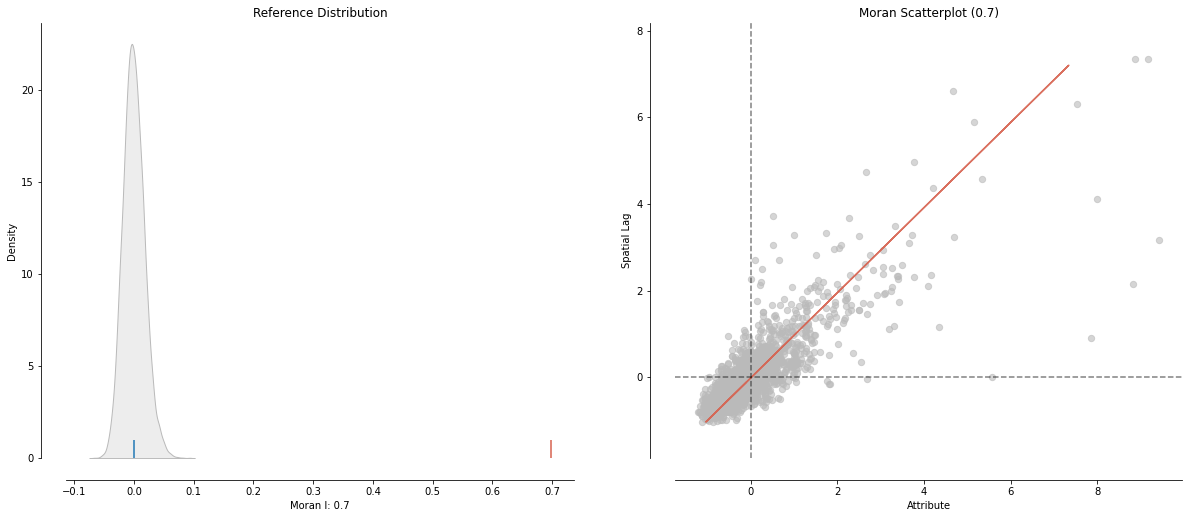

('WARNING: ', 168, ' is an island (no neighbors)')
('WARNING: ', 195, ' is an island (no neighbors)')
('WARNING: ', 204, ' is an island (no neighbors)')
('WARNING: ', 514, ' is an island (no neighbors)')
('WARNING: ', 553, ' is an island (no neighbors)')
('WARNING: ', 554, ' is an island (no neighbors)')
('WARNING: ', 723, ' is an island (no neighbors)')
('WARNING: ', 792, ' is an island (no neighbors)')
('WARNING: ', 804, ' is an island (no neighbors)')
('WARNING: ', 836, ' is an island (no neighbors)')
('WARNING: ', 891, ' is an island (no neighbors)')
('WARNING: ', 939, ' is an island (no neighbors)')
('WARNING: ', 1013, ' is an island (no neighbors)')
('WARNING: ', 1085, ' is an island (no neighbors)')
('WARNING: ', 1100, ' is an island (no neighbors)')
('WARNING: ', 1281, ' is an island (no neighbors)')
('WARNING: ', 1362, ' is an island (no neighbors)')
('WARNING: ', 1530, ' is an island (no neighbors)')
('WARNING: ', 1728, ' is an island (no neighbors)')
0.6788503842183623


<Figure size 432x288 with 0 Axes>

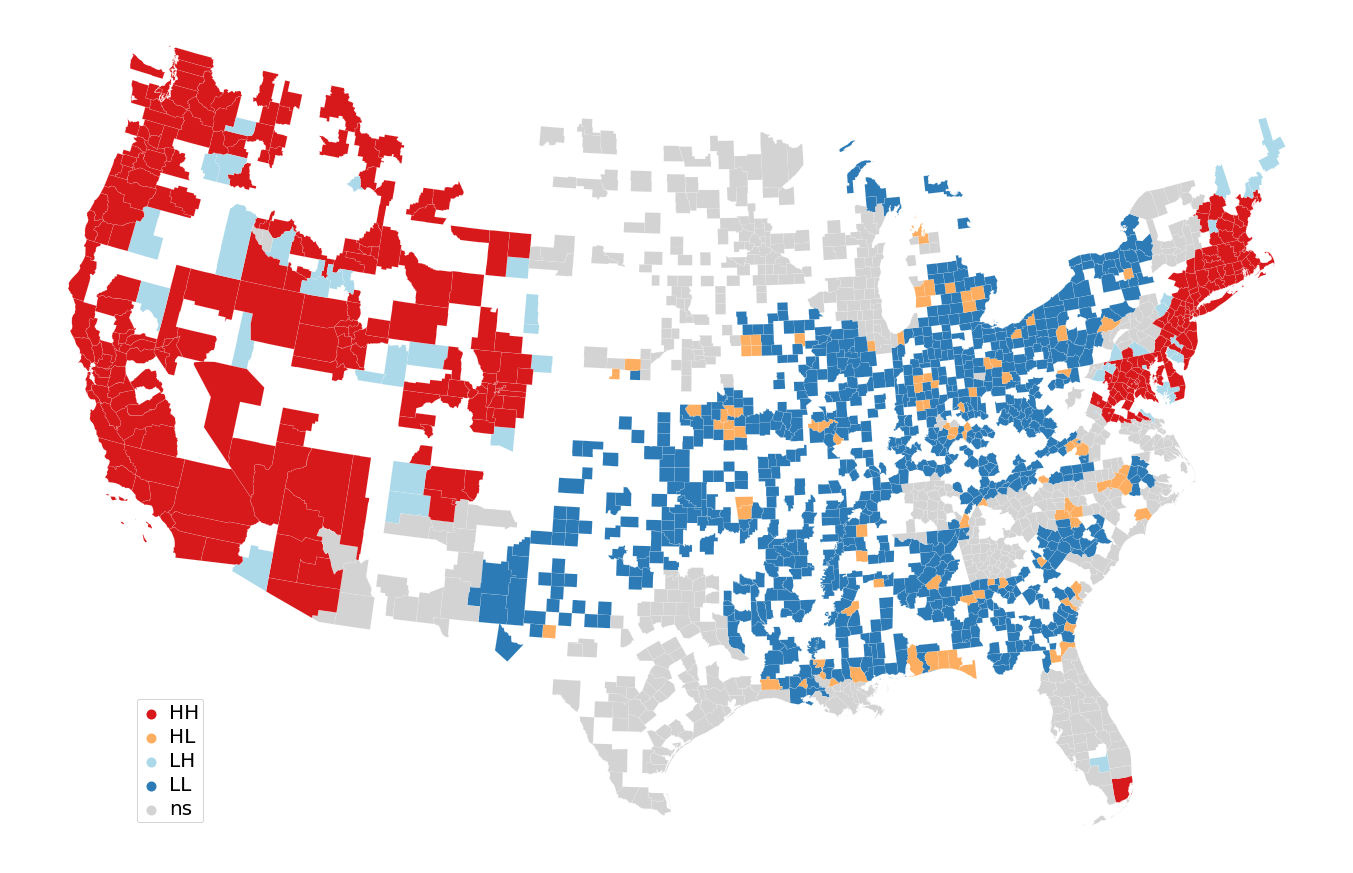

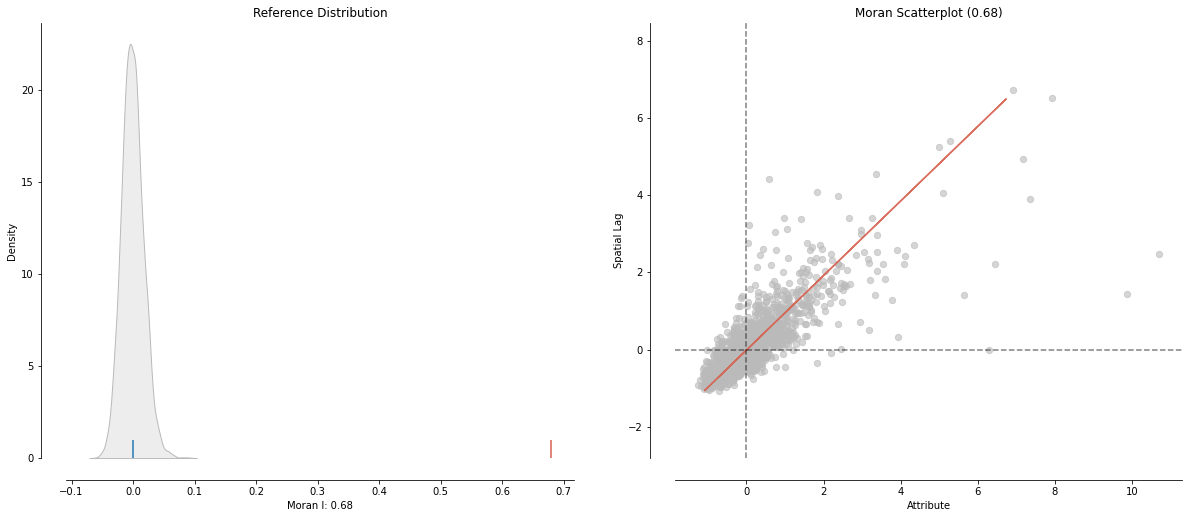

('WARNING: ', 168, ' is an island (no neighbors)')
('WARNING: ', 195, ' is an island (no neighbors)')
('WARNING: ', 204, ' is an island (no neighbors)')
('WARNING: ', 514, ' is an island (no neighbors)')
('WARNING: ', 553, ' is an island (no neighbors)')
('WARNING: ', 554, ' is an island (no neighbors)')
('WARNING: ', 723, ' is an island (no neighbors)')
('WARNING: ', 792, ' is an island (no neighbors)')
('WARNING: ', 804, ' is an island (no neighbors)')
('WARNING: ', 836, ' is an island (no neighbors)')
('WARNING: ', 891, ' is an island (no neighbors)')
('WARNING: ', 939, ' is an island (no neighbors)')
('WARNING: ', 1013, ' is an island (no neighbors)')
('WARNING: ', 1085, ' is an island (no neighbors)')
('WARNING: ', 1100, ' is an island (no neighbors)')
('WARNING: ', 1281, ' is an island (no neighbors)')
('WARNING: ', 1362, ' is an island (no neighbors)')
('WARNING: ', 1530, ' is an island (no neighbors)')
('WARNING: ', 1728, ' is an island (no neighbors)')
0.6935028978443064


<Figure size 432x288 with 0 Axes>

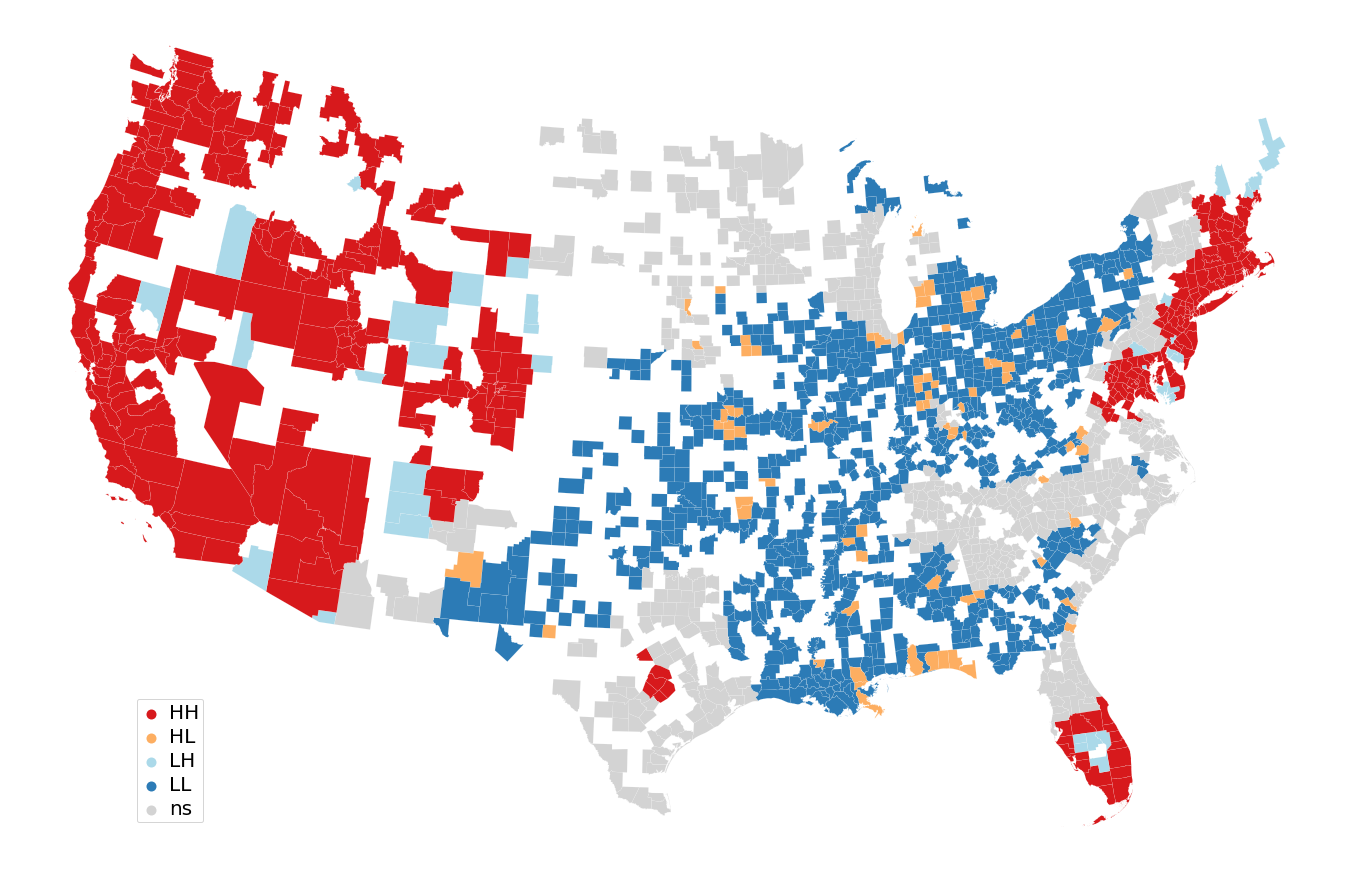

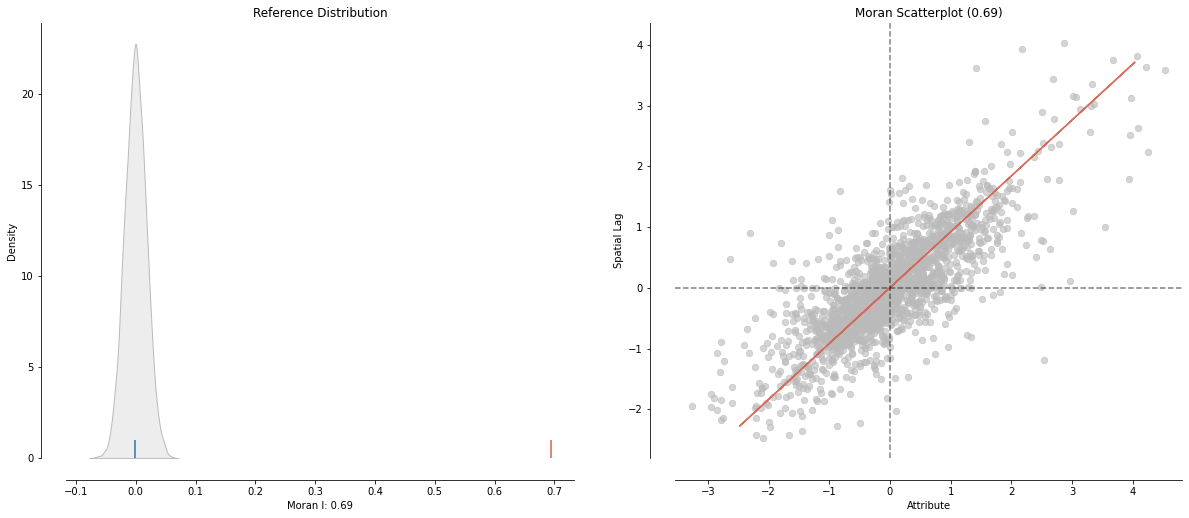

<Figure size 432x288 with 0 Axes>

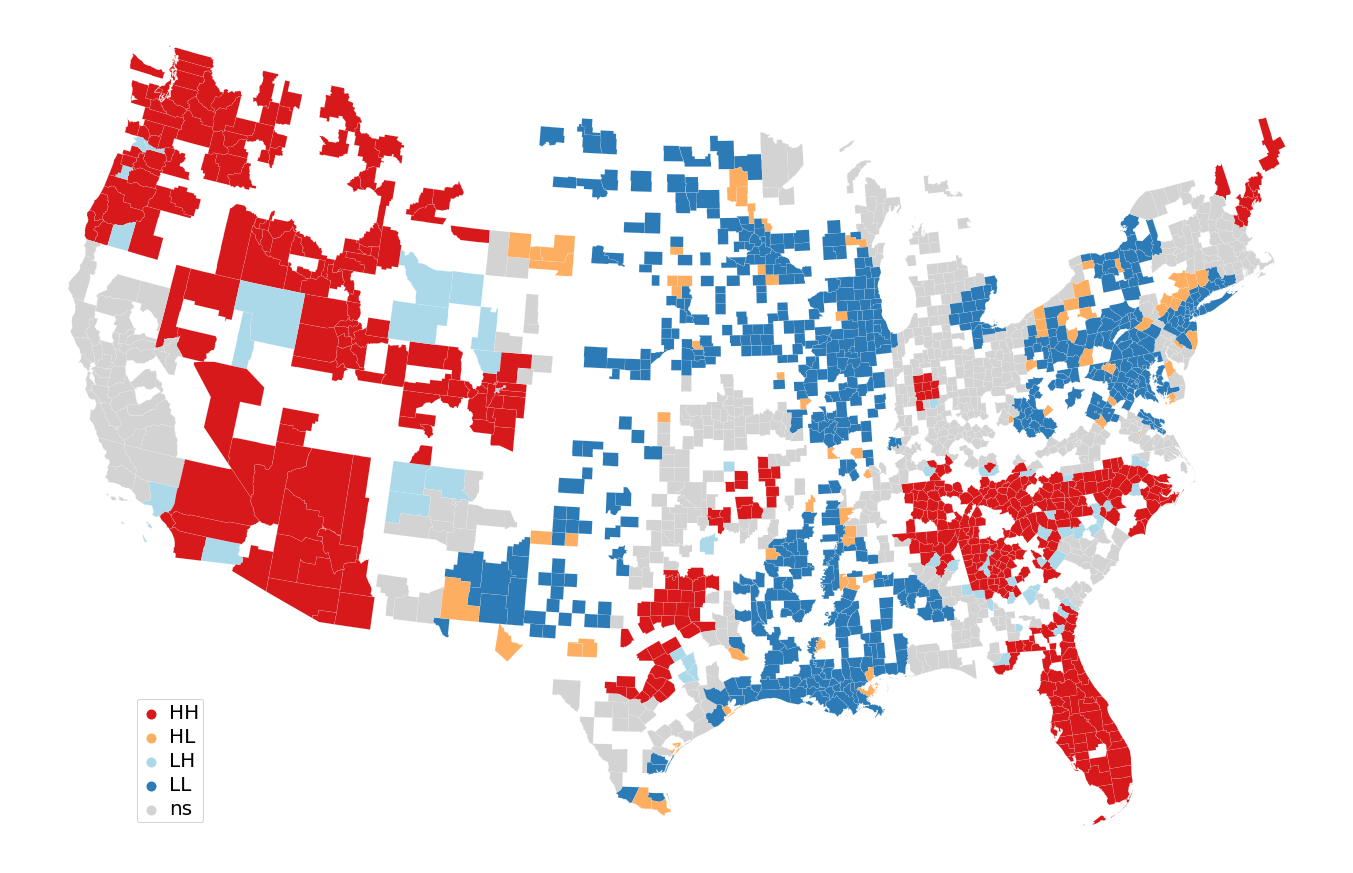

In [145]:
# Global Moran's I  and LISA analysis for housing prices in 2019, 2022 and housing price change respectively
for ch in ["avg_2019","avg_2022","price_changes"]:
    from pysal.lib import weights
    from pysal.explore import esda
    from pysal.viz import splot
    
    # Global Moran's I
    weight_g=weights.contiguity.Queen.from_dataframe(county_housing)
    weight_g.transform="r"
    values=county_housing[ch]
    morani=esda.moran.Moran(values, weight_g, permutations=9999)
    print(morani.I)
    # Moran scatterplot
    from splot.esda import plot_moran
    plot_moran(morani,zstandard=True,figsize=(20,8))
    plt.show()
    # All show significant clustering patterns
    
    plt.savefig(os.path.join(path_output, "global_%s.jpg"%ch), dpi=600)
    
    # lISA
    from splot.esda import lisa_cluster
    from splot.esda import moran_scatterplot
    weight_l=weights.distance.Kernel.from_dataframe(county_housing, fixed=False, k=50)
    morani_loc=esda.moran.Moran_Local(values, weight_l, permutations=9999)
    # Create a hot-spot and cold-spot map
    fig, ax = lisa_cluster(morani_loc, county_housing, p=0.05, figsize=(24, 40))
    legend = ax.get_legend()
    legend.set_bbox_to_anchor((0.15, 0.2))
    legend_fontsize = 20  
    for text in legend.get_texts():
        text.set_fontsize(legend_fontsize)
    
    plt.savefig(os.path.join(path_output, "lisa_%s.jpg"%ch), dpi=600)

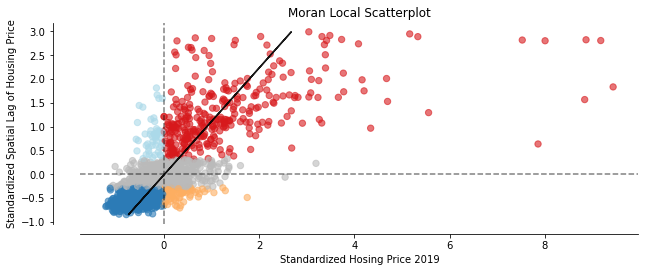

<Figure size 432x288 with 0 Axes>

In [158]:
# Generate a better Moran Scatterplot with significance of the local moran's Is
fig, ax = plt.subplots(figsize=(10, 10))
morani_loc=esda.moran.Moran_Local(county_housing["avg_2019"], weight_l, permutations=9999)
moran_scatterplot(morani_loc, p=0.05, aspect_equal=True, ax=ax)
ax.set_xlabel('Standardized Hosing Price 2019')
ax.set_ylabel('Standardized Spatial Lag of Housing Price')
plt.show()    

plt.savefig(os.path.join(path_output,"local_avg_2019.jpg"),dpi=600)

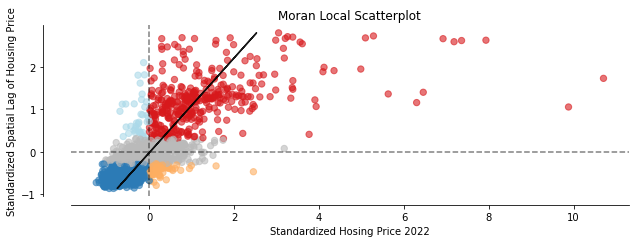

<Figure size 432x288 with 0 Axes>

In [159]:
fig, ax = plt.subplots(figsize=(10, 10))
morani_loc=esda.moran.Moran_Local(county_housing["avg_2022"], weight_l, permutations=9999)
moran_scatterplot(morani_loc, p=0.05, aspect_equal=True, ax=ax)
ax.set_xlabel('Standardized Hosing Price 2022')
ax.set_ylabel('Standardized Spatial Lag of Housing Price')
plt.show()    

plt.savefig(os.path.join(path_output,"local_avg_2022.jpg"),dpi=600)

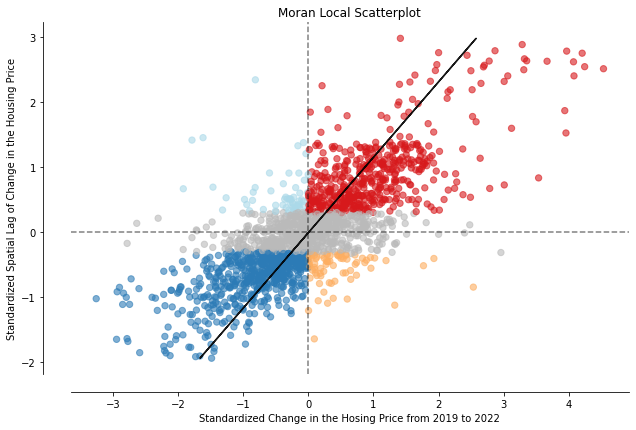

<Figure size 432x288 with 0 Axes>

In [160]:
fig, ax = plt.subplots(figsize=(10, 10))
morani_loc=esda.moran.Moran_Local(county_housing["price_changes"], weight_l, permutations=9999)
moran_scatterplot(morani_loc, p=0.05, aspect_equal=True, ax=ax)
ax.set_xlabel('Standardized Change in the Hosing Price from 2019 to 2022')
ax.set_ylabel('Standardized Spatial Lag of Change in the Housing Price')
plt.show()    

plt.savefig(os.path.join(path_output,"local_price_changes.jpg"),dpi=600)